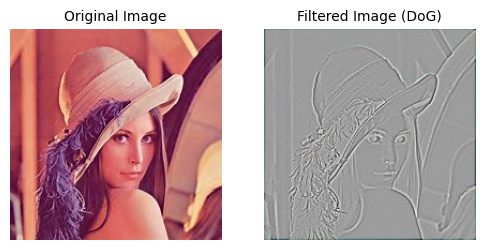

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def DoGFilter(size, sigma_1, sigma_2, step=1.0, zero_mean=False, one_sum=False, device=None, dtype=None):
    scale = (size - 1) / 2

    v_range = torch.arange(-scale, scale + step, step, dtype=dtype, device=device)
    x, y = torch.meshgrid(v_range, v_range, indexing="ij")

    g_values = -(x**2 + y**2) / 2

    dog_1 = torch.exp(g_values / (sigma_1**2)) / sigma_1
    dog_2 = torch.exp(g_values / (sigma_2**2)) / sigma_2

    dog_filter = (dog_1 - dog_2) / torch.sqrt(torch.tensor(2 * torch.pi, device=device, dtype=dtype))

    if zero_mean:
        p_sum = torch.sum(dog_filter[dog_filter > 0])
        n_sum = torch.sum(dog_filter[dog_filter < 0])
        dog_filter[dog_filter < 0] *= -p_sum / n_sum

    if one_sum:
        dog_filter /= torch.sum(torch.abs(dog_filter))

    return dog_filter

img = plt.imread("lena.jpg")
if img.shape[2] == 4:
    img = img[..., :3]  
img_tensor = torch.tensor(img, dtype=torch.float32)

size = 15
sigma_1 = 1
sigma_2 = 0.6

dog_filter = DoGFilter(size, sigma_1, sigma_2, zero_mean=True, one_sum=False, device=img_tensor.device, dtype=img_tensor.dtype)

filtered_img = torch.zeros_like(img_tensor)
for c in range(3): 
    channel = img_tensor[:, :, c].unsqueeze(0).unsqueeze(0)  
    filtered_channel = F.conv2d(channel, dog_filter.unsqueeze(0).unsqueeze(0), padding=size//2)
    filtered_img[:, :, c] = filtered_channel.squeeze()

filtered_img_np = filtered_img.numpy()
filtered_img_np = (filtered_img_np - filtered_img_np.min()) / (filtered_img_np.max() - filtered_img_np.min())

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img)
axs[0].set_title("Original Image", fontsize=10)
axs[0].axis("off")

axs[1].imshow(filtered_img_np)
axs[1].set_title("Filtered Image (DoG)", fontsize=10)
axs[1].axis("off")

plt.show()
